# 通し課題模範解答 分類編 DAY 3
- kaggle の kickstarter project に関して，成功・失敗を予測するモデルを作成する
    - https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv
- DAY 3 では，以下を行う
    - 特徴選択
        - フィルタ法
        - ラッパー法
        - 埋め込み法
    - 木モデルの利用
        - 決定木
        - ランダムフォレスト
        - アダブースト
    - ニューラルネットワークの利用

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('../data/df_classification.csv', index_col='ID')
df.head()

,period,log_usd_goal,n_words,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,state_successful
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,58,3.185811,6,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1000003930,59,4.477121,8,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1000004038,44,4.653213,3,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1000007540,29,3.698970,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1000014025,34,4.698970,3,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1


In [3]:
X = df.drop(columns='state_successful')
y = df['state_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [4]:
std = StandardScaler()
X_train.loc[:, ['log_usd_goal', 'period']] = std.fit_transform(X_train.loc[:, ['log_usd_goal', 'period']])
X_test.loc[:, ['log_usd_goal', 'period']] = std.transform(X_test.loc[:, ['log_usd_goal', 'period']])

/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## 特徴選択
### フィルタ法
- 相関係数による特徴選択を検討する

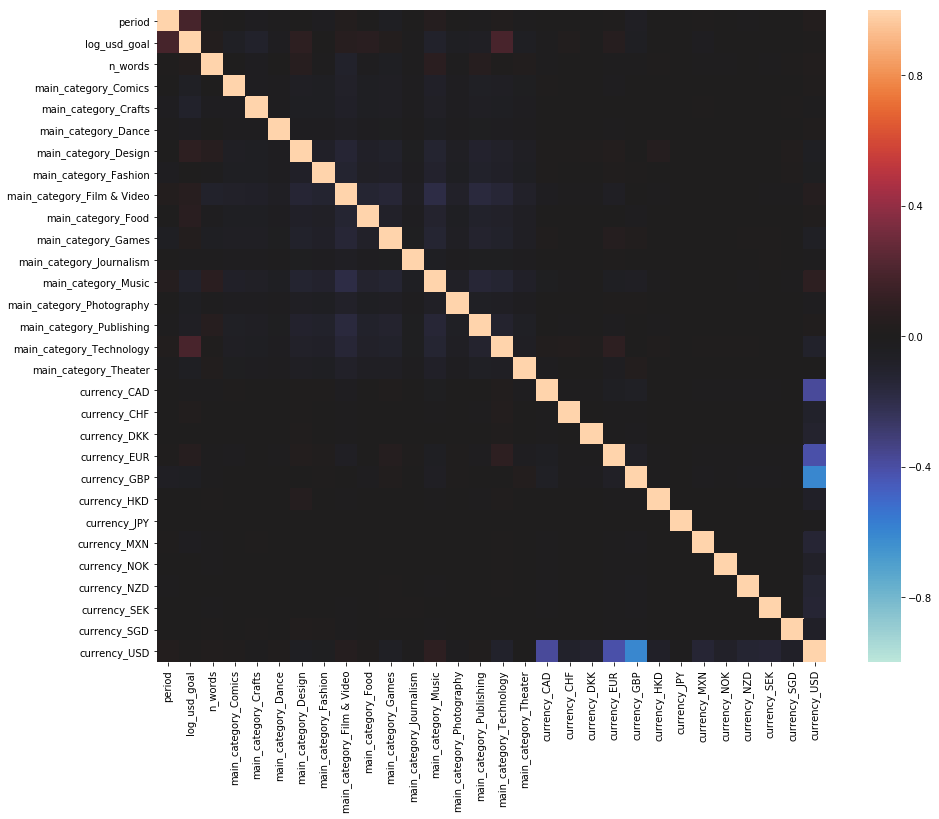

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
sns.heatmap(X_train.corr(), center=0, vmax=1, vmin=-1, ax=ax)

In [6]:
# 相関係数の絶対値が 0.3 以上 1.0 未満であるものを列挙
X_corr = X_train.corr().abs()
X_corr = X_corr.unstack()
X_corr = X_corr.sort_values(kind="quicksort")
X_corr[(0.2 < X_corr) & (X_corr < 1)]

currency_USD  currency_CAD    0.381138
currency_CAD  currency_USD    0.381138
currency_EUR  currency_USD    0.410704
currency_USD  currency_EUR    0.410704
              currency_GBP    0.603659
currency_GBP  currency_USD    0.603659
dtype: float64

最大で相関係数の絶対値が 0.6 程度であるため高いとは言えず，変数の削除の必要性はないと判断できる

### ラッパー法
- ステップワイズ法による特徴選択を行う

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

In [8]:
lr_clf = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
rfecv = RFECV(lr_clf, cv=kf, scoring='accuracy', verbose=3)
rfecv.fit(X_train, y_train)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.

RFECV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
      estimator=SGDClassifier(loss='log', max_iter=10000, random_state=1234),
      scoring='accuracy', verbose=3)

In [9]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 2 1 1 6 1 1 4 3 1 1]


In [10]:
y_pred = rfecv.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.647
Precision: 0.565
Recall: 0.545
F1: 0.555


線形モデルに対しては特徴選択は効果が薄い．

### 埋め込み法
- L_1 正則化によって特徴選択を行う

In [11]:
lr_cv = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=kf, max_iter=10000, random_state=1234, tol=1e-3, verbose=3)
sfm = SelectFromModel(lr_cv, threshold=1e-5)
sfm.fit(X_train, y_train)

[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.5s finished


[LibLinear]

SelectFromModel(estimator=LogisticRegressionCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                                               max_iter=10000, penalty='l1',
                                               random_state=1234,
                                               solver='liblinear', tol=0.001,
                                               verbose=3),
                threshold=1e-05)

In [12]:
X_train_l1 = X_train.loc[:, sfm.get_support()]
X_test_l1 = X_test.loc[:, sfm.get_support()]

In [13]:
lr_clf = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
lr_clf.fit(X_train_l1, y_train)

y_pred = lr_clf.predict(X_test_l1)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.647
Precision: 0.565
Recall: 0.545
F1: 0.555


線形モデルに対しては特徴選択は効果が薄い．

##  木モデルの利用
### 決定木
以下をチューニングしつつ学習
- max_depth: 木の深さの最大値
- min_samples_leaf: 1つのノードに許される最小サンプルサイズ

In [14]:
parameters = {'max_depth': range(10, 15), 'min_samples_leaf': range(1, 5)}

dtc = DecisionTreeClassifier(criterion='entropy', random_state=1234)
grid = GridSearchCV(dtc, param_grid=parameters, 
                         cv=kf, 
                         scoring='accuracy', 
                         verbose=3) 

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... max_depth=10, min_samples_leaf=1, score=0.655, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .... max_depth=10, min_samples_leaf=1, score=0.653, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] .... max_depth=10, min_samples_leaf=1, score=0.657, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1 ................................
[CV] .... max_depth=10, min_samples_leaf=1, score=0.655, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1 ................................
[CV] .... max_depth=10, min_samples_leaf=1, score=0.652, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] .... max_depth=10, min_samples_leaf=2, score=0.655, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] .... max_depth=10, min_samples_leaf=2, score=0.654, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] .... max_depth=10, min_samples_leaf=2, score=0.657, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] .... max_depth=10, min_samples_leaf=2, score=0.655, total=   0.7s
[CV] max_depth=10, min_samples_leaf=2 ................................
[CV] .

[CV] .... max_depth=13, min_samples_leaf=1, score=0.658, total=   0.9s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] .... max_depth=13, min_samples_leaf=1, score=0.658, total=   0.8s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] .... max_depth=13, min_samples_leaf=1, score=0.659, total=   0.8s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] .... max_depth=13, min_samples_leaf=1, score=0.660, total=   0.8s
[CV] max_depth=13, min_samples_leaf=1 ................................
[CV] .... max_depth=13, min_samples_leaf=1, score=0.657, total=   0.8s
[CV] max_depth=13, min_samples_leaf=2 ................................
[CV] .... max_depth=13, min_samples_leaf=2, score=0.658, total=   0.8s
[CV] max_depth=13, min_samples_leaf=2 ................................
[CV] .... max_depth=13, min_samples_leaf=2, score=0.657, total=   0.8s
[CV] max_depth=13, min_samples_leaf=2 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=1234),
             param_grid={'max_depth': range(10, 15),
                         'min_samples_leaf': range(1, 5)},
             scoring='accuracy', verbose=3)

In [15]:
y_pred = grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.658
Precision: 0.602
Recall: 0.455
F1: 0.518


In [16]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=2,
                       random_state=1234)

通常のロジスティック回帰にくらべて性能は良くなった

### ランダムフォレスト
以下をチューニングしつつ学習．実行に30分ほどかかるので注意する
- n_estimators: 弱学習器の数

In [17]:
parameters = {'n_estimators': range(50, 100, 10)}

rfc = RandomForestClassifier(criterion='entropy', random_state=1234)
grid = GridSearchCV(rfc, param_grid=parameters, 
                         cv=kf, 
                         scoring='accuracy', 
                         verbose=3) 

grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=50, score=0.630, total=  12.2s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV] ..................... n_estimators=50, score=0.633, total=  12.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.4s remaining:    0.0s


[CV] ..................... n_estimators=50, score=0.632, total=  11.8s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.635, total=  12.8s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.634, total=  13.3s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.631, total=  15.8s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.633, total=  14.5s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.633, total=  14.5s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.635, total=  15.2s
[CV] n_estimators=60 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  7.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=1234),
             param_grid={'n_estimators': range(50, 100, 10)},
             scoring='accuracy', verbose=3)

In [18]:
y_pred = grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.63
Precision: 0.548
Recall: 0.475
F1: 0.509


In [19]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', n_estimators=70, random_state=1234)

- 決定木より精度が落ちてしまった
- CV のスコアを見る限り，`n_estimators`に対してロバストであると推察できる

### アダブースト
決定木を弱学習器としたアダブーストを，以下をチューニングしながら学習
- n_estimators: 弱学習器の数

In [20]:
parameters = {'n_estimators': range(50, 100, 10)}

abc = AdaBoostClassifier(random_state=1234)
grid = GridSearchCV(estimator=abc, param_grid=parameters, 
                         cv=kf, 
                         scoring='accuracy', 
                         verbose=3) 

grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=50, score=0.664, total=   5.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] ..................... n_estimators=50, score=0.666, total=   5.8s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s


[CV] ..................... n_estimators=50, score=0.666, total=   5.4s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.662, total=   5.0s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.666, total=   5.0s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.664, total=   6.2s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.667, total=   6.1s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.666, total=   6.1s
[CV] n_estimators=60 .................................................
[CV] ..................... n_estimators=60, score=0.663, total=   6.0s
[CV] n_estimators=60 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=AdaBoostClassifier(random_state=1234),
             param_grid={'n_estimators': range(50, 100, 10)},
             scoring='accuracy', verbose=3)

In [21]:
y_pred = grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.664
Precision: 0.608
Recall: 0.471
F1: 0.531


In [22]:
grid.best_estimator_

AdaBoostClassifier(n_estimators=90, random_state=1234)

決定木を上回る性能が達成された

## ニューラルネットワークの利用
- FutureWarning は無視して良い

In [23]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [24]:
model = Sequential()
model.add(Input(shape=(len(X_train.columns),)))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall()],
)

WARNING - From /Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
WARNING - From /Users/mizoguchi/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, y_test),
)

Train on 232170 samples, validate on 99502 samples
Epoch 1/10
232170/232170 [==============================] - 6s 26us/sample - loss: 0.6164 - binary_accuracy: 0.6530 - precision: 0.5903 - recall: 0.4600 - val_loss: 0.6095 - val_binary_accuracy: 0.6598 - val_precision: 0.5942 - val_recall: 0.4980
Epoch 2/10
232170/232170 [==============================] - 6s 24us/sample - loss: 0.6079 - binary_accuracy: 0.6602 - precision: 0.6028 - recall: 0.4654 - val_loss: 0.6053 - val_binary_accuracy: 0.6614 - val_precision: 0.5932 - val_recall: 0.5147
Epoch 3/10
232170/232170 [==============================] - 5s 23us/sample - loss: 0.6053 - binary_accuracy: 0.6631 - precision: 0.6069 - recall: 0.4702 - val_loss: 0.6028 - val_binary_accuracy: 0.6644 - val_precision: 0.6229 - val_recall: 0.4287
Epoch 4/10
232170/232170 [==============================] - 5s 23us/sample - loss: 0.6039 - binary_accuracy: 0.6641 - precision: 0.6081 - recall: 0.4733 - val_loss: 0.6070 - val_binary_accuracy: 0.6620 - val_

Adaboost と同等の性能が得られた